Using cpu device
NeuralNetwork(
  (Encoder): Sequential(
    (0): Conv2d(1, 20, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(20, 20, kernel_size=(4, 4), stride=(2, 2))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Dropout(p=0.1, inplace=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=500, out_features=250, bias=True)
    (11): ReLU()
    (12): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Dropout(p=0.1, inplace=False)
    (14): Linear(in_features=250, out_features=10, bias=True)
  )
  (Decoder): Sequential(
    (0): Linear(in_features=10, out_features=360, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(360, eps=1e-

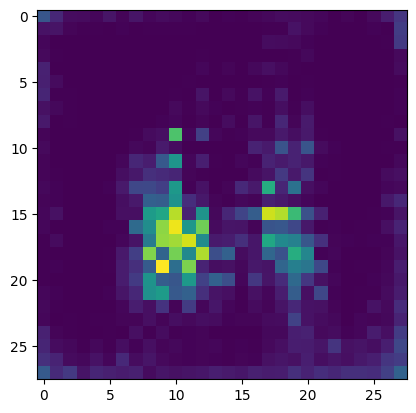

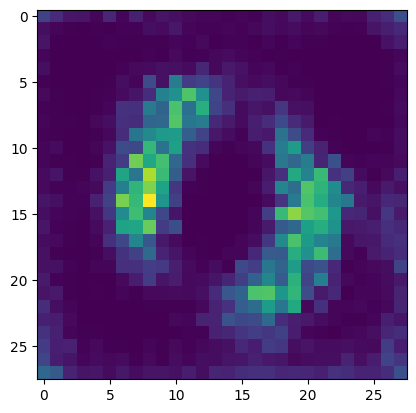

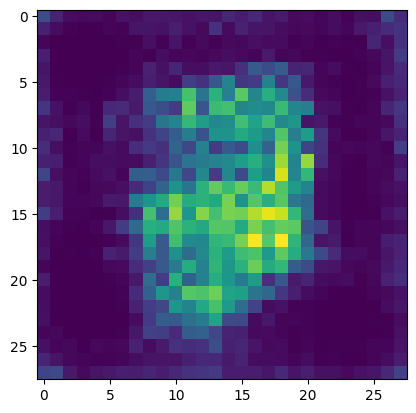

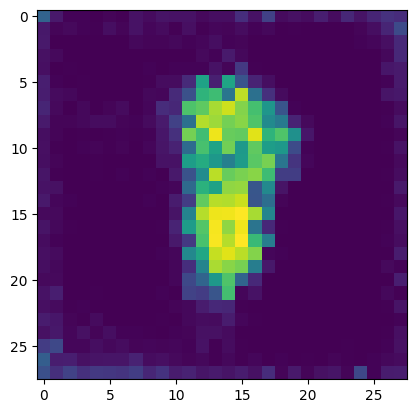

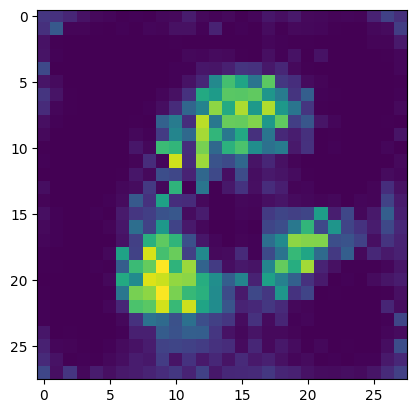

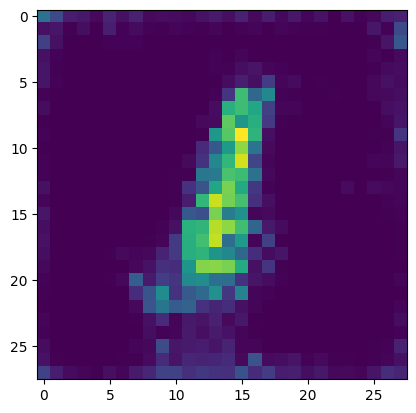

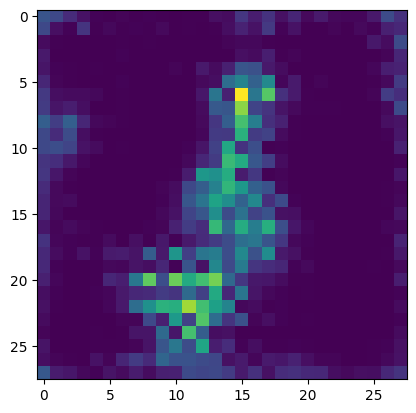

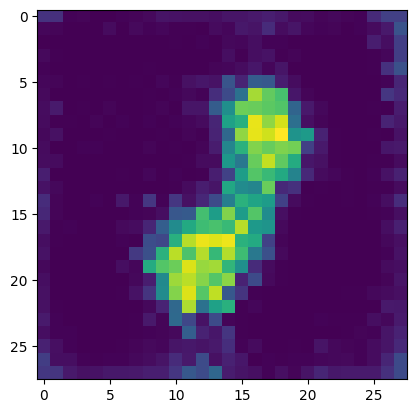

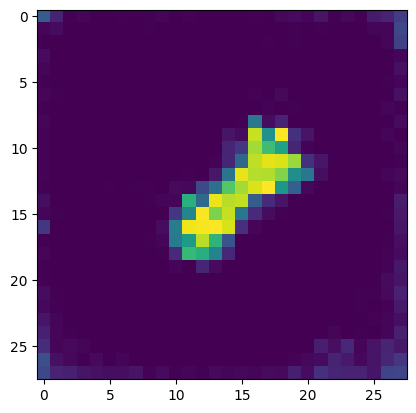

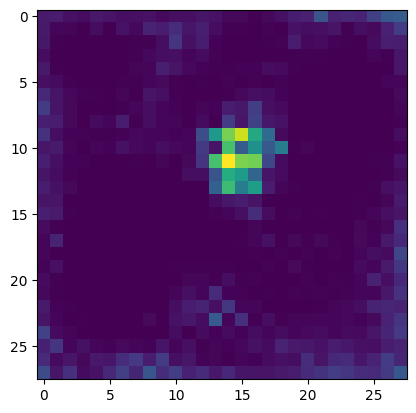

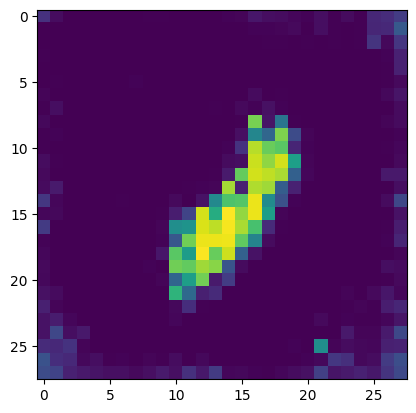

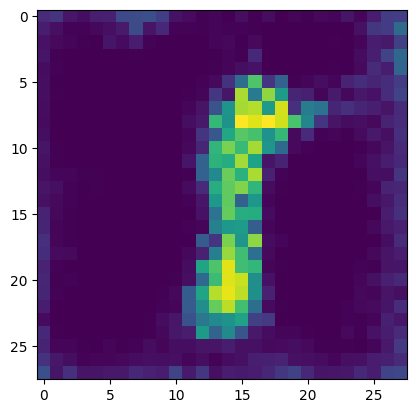

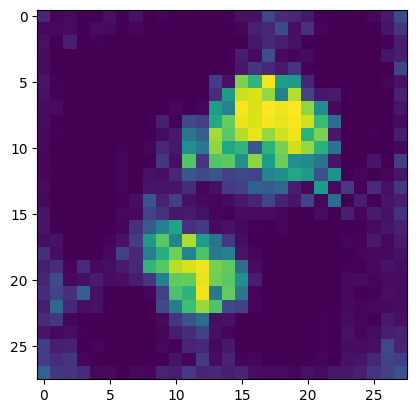

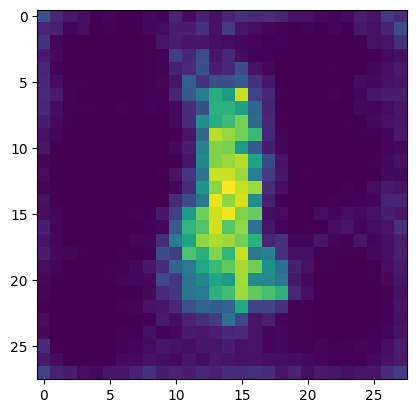

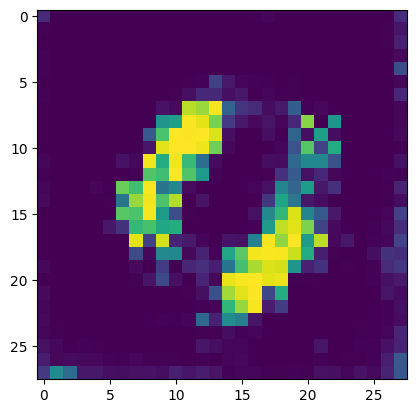

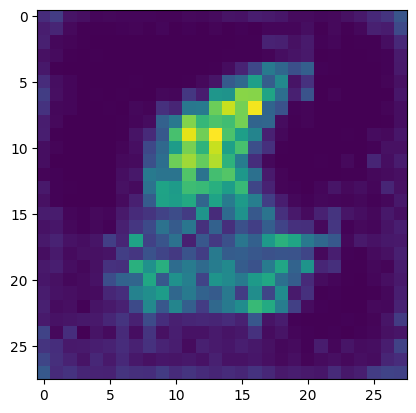

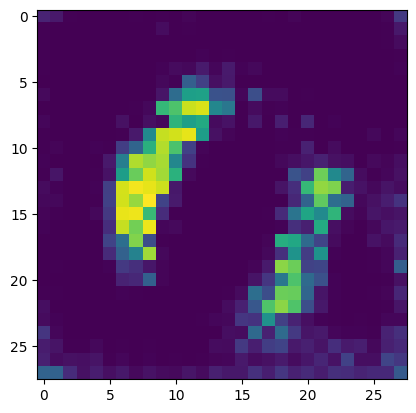

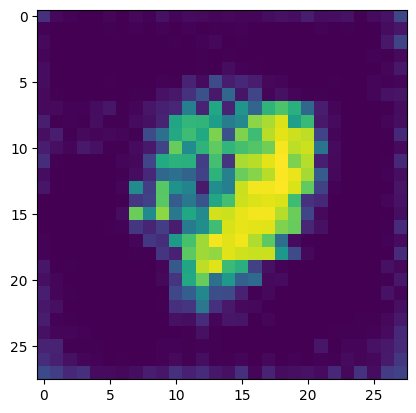

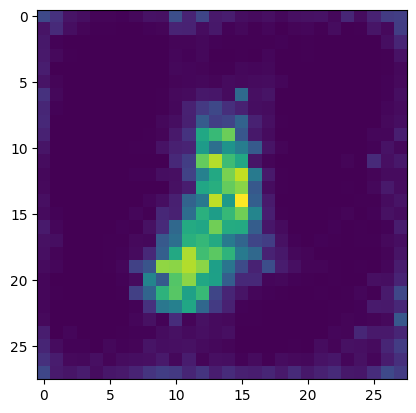

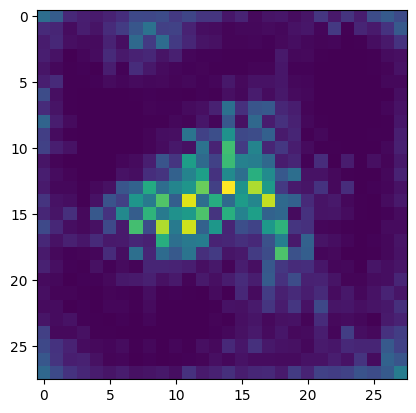

In [ ]:
# *****************************************************************************
# *****************************************************************************
# Gaussian Autoencoder
# *****************************************************************************
# *****************************************************************************

# *****************************************************************************
# Preamble and dataset loading, based on PyTorch tutorial
# *****************************************************************************
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import random
import numpy as np
import matplotlib.pyplot as plt

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

torch.set_default_device(device)
print(f"Using {device} device")

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

batch_size = 64 #!!! Fill in !!!#

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

# *****************************************************************************
# Building the neural network
# *****************************************************************************
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.Encoder = nn.Sequential( # Same as HW6's CNN
            nn.Conv2d(1,20,4,1),
            nn.ReLU(),
            nn.BatchNorm2d(20),
            nn.Dropout(0.1),
            nn.Conv2d(20,20,4,2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(20),
            nn.Dropout(0.1),
            nn.Flatten(),
            nn.Linear(500, 250),
            nn.ReLU(),
            nn.BatchNorm1d(250),
            nn.Dropout(0.1),
            nn.Linear(250, 10)
        )
        self.Decoder = nn.Sequential(
            nn.Linear(10, 360),
            nn.ReLU(),
            nn.BatchNorm1d(360),
            nn.Dropout(0.1),
            nn.Linear(360, 720),
            nn.ReLU(),
            nn.Unflatten(1, (20, 6, 6)),
            nn.BatchNorm2d(20),
            nn.Dropout(0.1),
            nn.Upsample(scale_factor=2, mode='bicubic'),
            nn.ConvTranspose2d(20, 20, 4, 2, 1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(20),
            nn.Dropout(0.1),
            nn.ConvTranspose2d(20, 1, 4, 1),
            nn.Sigmoid()
        )

        self.flatten = nn.Flatten()

    def forward(self, x, enc_mode=1):
        z = self.Encoder(x)
        z2 = enc_mode*z + (2-enc_mode)*torch.randn(z.shape)
        f = self.Decoder(z2)
        e = f - x
        e = self.flatten(e)
        e = torch.cat((z, e), dim=1)
        return e


model = NeuralNetwork().to(device)

# *****************************************************************************
# Train and test loops
# *****************************************************************************
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X.to(device))
        loss = loss_fn(pred, torch.zeros_like(pred)) #!!! Fill in !!!

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0
    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.to(device))
            test_loss += loss_fn(pred, torch.zeros_like(pred)).item() #!!! Fill in !!!
    test_loss /= num_batches
    print(f"Avg loss: {test_loss:>8f} \n {size} {num_batches}")

# *****************************************************************************
# Optimization prameters and initialization
# *****************************************************************************
loss_fn = nn.MSELoss() #!!! Fill in !!!
learning_rate = 0.01 #!!! Fill in !!!#
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# *****************************************************************************
# Standard training epochs
# *****************************************************************************
print(model)
print("Training model...")
epochs = 10 #!!! Fill in !!!#
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

# *****************************************************************************
# Generating new images using the learned autoencoder
# *****************************************************************************
for s in range(20):
    x = model(torch.zeros(1, 1, 28, 28), enc_mode=0)
    imgX = x[0, 10:].reshape(28, 28).detach().to("cpu")
    plt.imshow(imgX)
    plt.show()

In [ ]:
class ImprovedAutoencoder(nn.Module):
    def __init__(self, latent_dim=32):
        super().__init__()
        self.Encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 3, padding=1, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 3, padding=1, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, latent_dim)
        )

        self.Decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 128 * 7 * 7),
            nn.ReLU(),
            nn.BatchNorm1d(128 * 7 * 7),
            nn.Unflatten(1, (128, 7, 7)),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 1, 3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x, enc_mode=1):
        z = self.Encoder(x)
        z2 = enc_mode * z + (2 - enc_mode) * torch.randn_like(z)
        f = self.Decoder(z2)
        e = f - x
        e = torch.flatten(e, start_dim=1)
        return torch.cat((z, e), dim=1)

# Modify training process
model = ImprovedAutoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

# Train for more epochs
epochs = 50

print(model)
print("Training model...")
epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss = test_loop(test_dataloader, model, loss_fn)
print("Done!")

# Visualize results
for s in range(20):
    x = model(torch.zeros(1, 1, 28, 28), enc_mode=0)
    imgX = x[0, 32:].reshape(28, 28).detach().cpu()
    plt.imshow(imgX, cmap='gray')
    plt.axis('off')
    plt.show()